In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("Sunspots.csv",index_col='Date',parse_dates=True) 
df.index.freqs='MS' 

In [3]:
display(df)

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7
...,...,...
2020-09-30,3260,0.6
2020-10-31,3261,14.4
2020-11-30,3262,34.0


Processing the data

In [4]:
import csv

# Processing and preparing the data
time_step = []
sunspots = []

with open("Sunspots.csv") as csvfile:  
    reader = csv.reader(csvfile, delimiter=',')  #C:\Users\deeks\OneDrive\Desktop\PROJECT\
    next(reader) # the next() function skips the first line (header) when looping
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [5]:
# For plotting the series or data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    myplot = plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunpots")
    if label != None:
        plt.legend()
    plt.grid(True)

Before plotting, the data gets converted to Numpy arrays

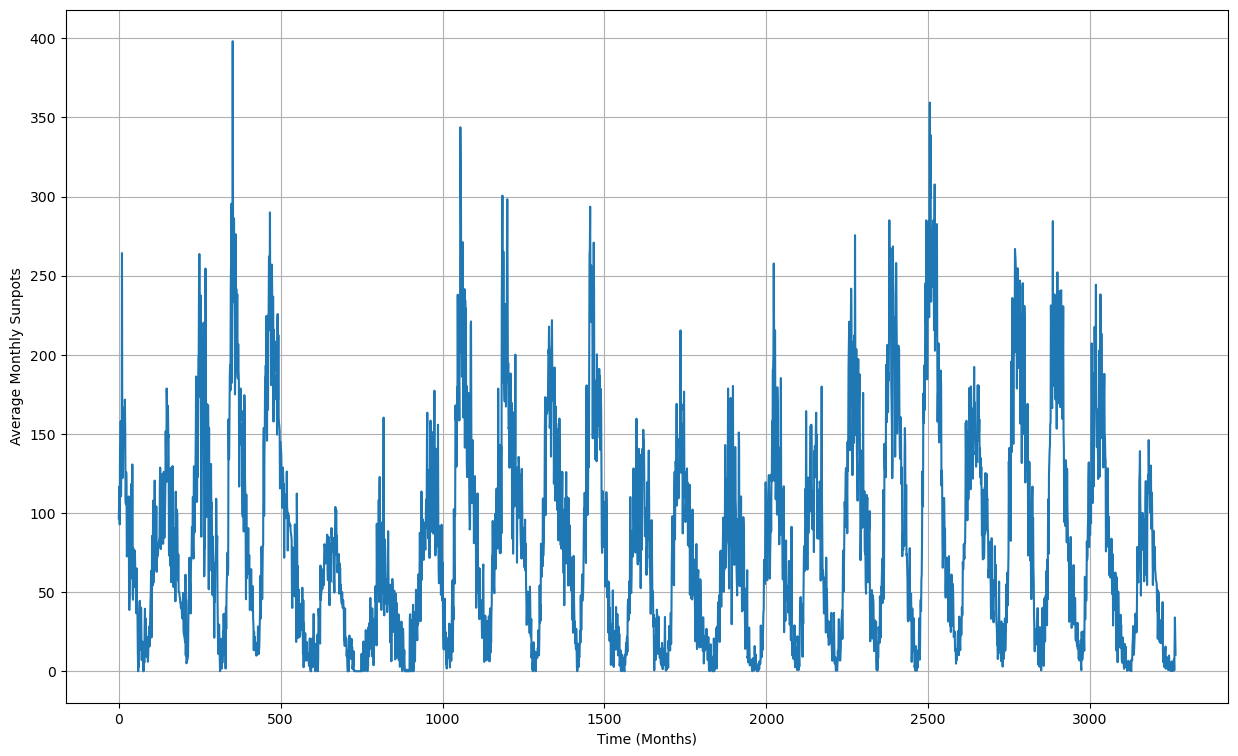

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
#Looking at the data
plt.figure(figsize=(15, 9))
plot_series(time, series)

In [7]:
# Adjusting the parameters & preparing the Model
split_time = 3000
window_size= 30
batch_size = 32
shuffle_buffer_zone = 1000

# Training data
#Splitting Training Data into Test and Validation Sets
train_time = time[:split_time]
X_train = series[:split_time]
# Validation data
valid_time = time[split_time:]
X_valid = series[split_time:]
     

Graphing help us understanding the split better

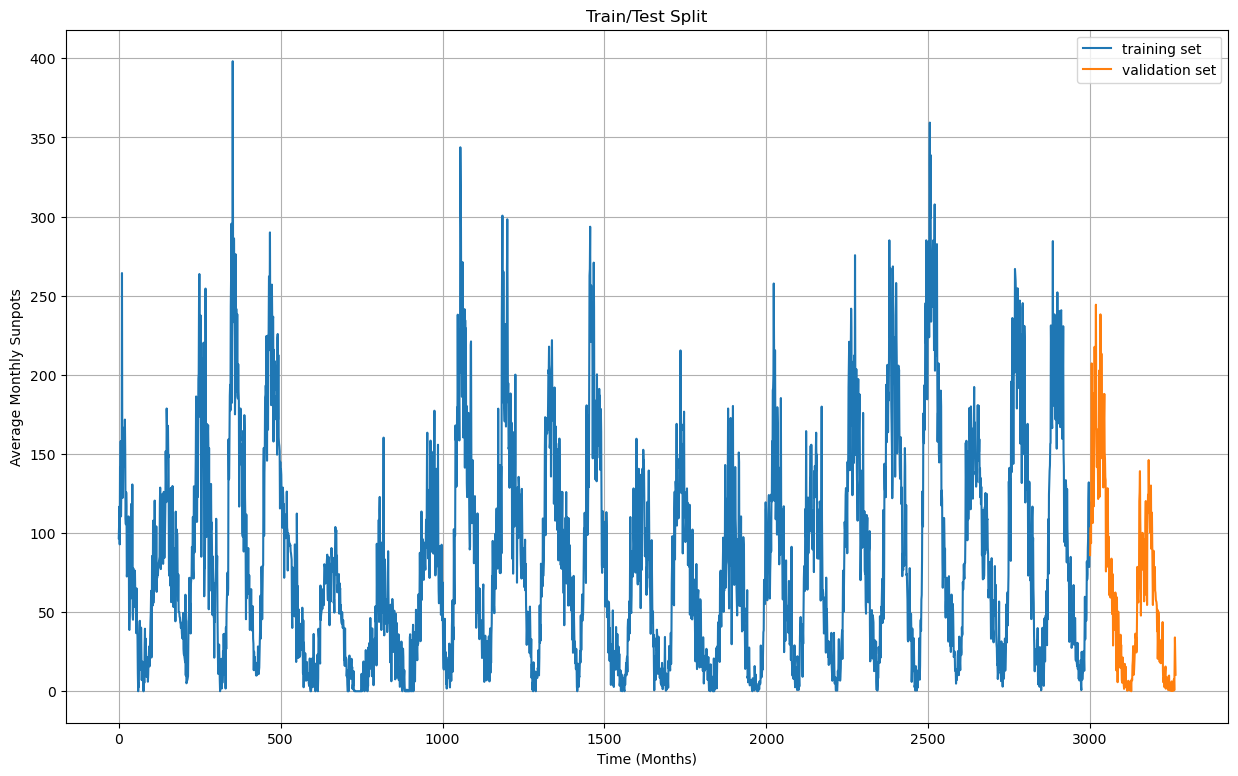

In [8]:
plt.figure(figsize=(15, 9))
plt.title("Train/Test Split")
plot_series(train_time, X_train, label="training set")
plot_series(valid_time, X_valid, label="validation set")

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

To demonstrate how the windowed_dataset function and the window_size parameter are slicing the data set, have a closer look at the graph below.

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np

# Clear any previous TensorFlow session
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_zone = 1000
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)
print(train_set)
print(X_train.shape)

# Define the GRU model with L2 regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           kernel_regularizer=regularizers.l2(0.01),  # L2 regularization with lambda = 0.01
                           input_shape=[None, 1]),
    tf.keras.layers.GRU(60, return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization with lambda = 0.01
    tf.keras.layers.GRU(60, return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization with lambda = 0.01
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization with lambda = 0.01
    tf.keras.layers.Dense(10, activation="relu",
                          kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization with lambda = 0.01
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Define the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Define the optimizer with the learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

# Compile the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer)

# Print the model summary
model.summary()

# Fit the model
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])



<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)


D:\Anaconda3-2024.02-1-Windows\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 60)            │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 60)            │          21,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 60)            │          21,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 30)            │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 10)            │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 1)             │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, None, 1)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,431 (181.37 KB)

 Trainable params: 46,431 (181.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 53.1858 - learning_rate: 1.0000e-08
Epoch 2/50


D:\Anaconda3-2024.02-1-Windows\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 52.7563 - learning_rate: 1.1220e-08
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 51.3546 - learning_rate: 1.2589e-08
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 50.6181 - learning_rate: 1.4125e-08
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 49.8207 - learning_rate: 1.5849e-08
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 48.5758 - learning_rate: 1.7783e-08
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 48.4576 - learning_rate: 1.9953e-08
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 47.9079 - learning_rate: 2.2387e-08
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 47.1829 - learning_rate: 2.5119e-08
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 46.5232 - learning_rate: 2.8184e-08
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 46.4561 - learning_rate: 3.1623e-08
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/s

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')
print("mae : ", tf.keras.metrics.mean_absolute_error(X_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(valid_time, X_valid)
plot_series(valid_time, rnn_forecast)

101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
First 10 Predictions : 
 [155.06557 144.75984 153.46579 160.78392 154.56165 166.50226 164.96419
 158.02206 153.0605  164.95193]



AttributeError: module 'keras._tf_keras.keras.metrics' has no attribute 'mean_absolute_error'

Forecasting and Evaluating Here, we see the last sun-spot cycle and how the model (orange) at least visually matches the training/validation (blue) data quite well.

In [13]:
# Calculating the mean absolute error
print('Mean Absolute Error (MAE): ',tf.keras.metrics.mean_absolute_error(X_valid, rnn_forecast).numpy())

AttributeError: module 'keras._tf_keras.keras.metrics' has no attribute 'mean_absolute_error'

In [14]:
for i in range(10,20):
    print(X_valid[i], " - ", rnn_forecast[i])

188.3  -  159.63995
116.8  -  148.27014
133.1  -  160.52286
165.7  -  162.24983
217.7  -  164.9956
191.5  -  185.0256
165.9  -  178.7168
188.0  -  179.00354
244.3  -  194.31696
180.5  -  198.53633


In [15]:
print(X_valid.shape)
print(rnn_forecast.shape)

from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(X_valid,rnn_forecast)
print("mse = ", mse)
rmse=sqrt(mse)
print("rmse = ", rmse)

(265,)
(265,)
mse =  825.5495250700035
rmse =  28.73237764387075


In [16]:
# Define the number of future time steps to forecast
future_steps = 100

# Function to generate forecasts
def generate_forecasts(model, series, window_size, future_steps):
    # Create a copy of the series to hold the forecasted values
    forecast_series = series.copy()
    
    # Iterate over the number of future steps to forecast
    for step in range(future_steps):
        # Extract the most recent window from the series
        recent_window = forecast_series[-window_size:]
        
        # Reshape the window to match the input shape expected by the model
        recent_window = recent_window.reshape(1, -1, 1)
        
        # Predict the next value using the model
        next_value = model.predict(recent_window)[0, -1, 0]
        
        # Append the predicted value to the forecast series
        forecast_series = np.append(forecast_series, next_value)
    
    return forecast_series

# Generate forecasts using the trained model and the training set
train_forecasts = generate_forecasts(model, X_train, window_size, future_steps)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

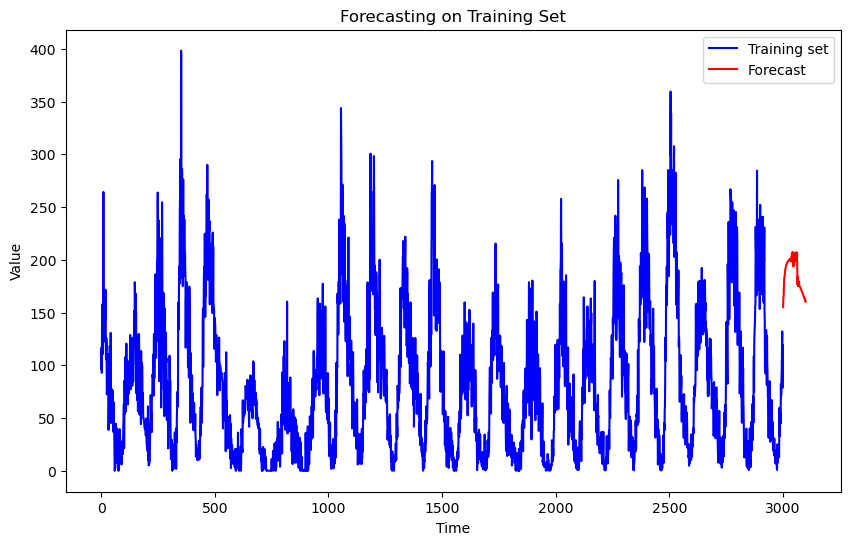

In [17]:
# Plot the original series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time[:len(X_train)], X_train, label='Training set', color='blue')
plt.plot(time[len(X_train):len(X_train)+future_steps], train_forecasts[-future_steps:], label='Forecast', color='red')
plt.title('Forecasting on Training Set')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
